In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import os
import shutil

In [2]:
base_dir = r'/kaggle/input/4weather/weather_classification'

In [3]:

train_dir = os.path.join(base_dir , 'train')
test_dir = os.path.join(base_dir , 'test')  

In [4]:
from torchvision import transforms

In [5]:
transform = transforms.Compose([
                  transforms.Resize((96, 96)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                       std=[0.5, 0.5, 0.5])
])

In [6]:
train_ds = torchvision.datasets.ImageFolder(
               train_dir,
               transform=transform
)

In [7]:
test_ds = torchvision.datasets.ImageFolder(
               test_dir,
               transform=transform
)

In [8]:
train_ds.classes

['cloudy', 'rain', 'shine', 'sunrise']

In [9]:
train_ds.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [10]:
len(train_ds), len(test_ds)

(900, 225)

In [11]:
BATCHSIZE = 16

In [12]:
train_dl = torch.utils.data.DataLoader(
                                       train_ds,
                                       batch_size=BATCHSIZE,
                                       shuffle=True
)

In [13]:
test_dl = torch.utils.data.DataLoader(
                                       test_ds,
                                       batch_size=BATCHSIZE,
)

In [14]:
imgs, labels = next(iter(train_dl))

In [15]:
imgs.shape

torch.Size([16, 3, 96, 96])

In [16]:
imgs[0].shape

torch.Size([3, 96, 96])

In [17]:
im = imgs[0].permute(1, 2, 0)

In [18]:
im.shape

torch.Size([96, 96, 3])

In [19]:
im = im.numpy()

In [20]:
type(im)

numpy.ndarray

In [21]:
im.shape

(96, 96, 3)

In [22]:
im = (im + 1)/2

In [23]:
im.max(), im.min()

(1.0, 0.0)

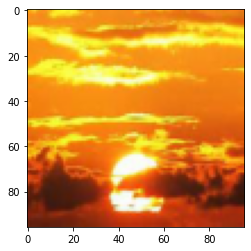

In [24]:
plt.imshow(im)

In [25]:
labels[0]

tensor(3)

In [26]:
train_ds.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [27]:
id_to_class = dict((v, k) for k, v in train_ds.class_to_idx.items())

In [28]:
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

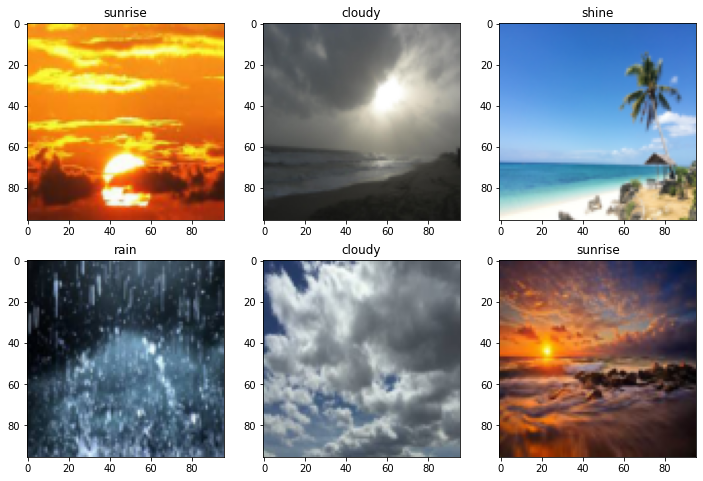

In [29]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1)/2
    plt.subplot(2, 3, i+1)
    plt.title(id_to_class.get(label.item()))
    plt.imshow(img)

# 添加dropout层

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.drop = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(64*10*10, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [31]:
model = Net()
if torch.cuda.is_available():
    model.to('cuda')

In [32]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [33]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=20, device='cuda'):
   
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()
    model.to(device)
    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
              (epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP
    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    plt.figure(dpi=150)
    plt.plot(range(1,epochs+1),history['loss'],label='train_loss')
    plt.plot(range(1,epochs+1),history['val_loss'],label='test_loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

    plt.figure(dpi=150)
    plt.plot(range(1,epochs+1),history['acc'],label='train_acc')
    plt.plot(range(1,epochs+1),history['val_acc'],label='test_acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()
    return history
     

train() called: model=Net, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  0.77, train acc:  0.65, val loss:  0.58, val acc:  0.70
Epoch   2/ 20, train loss:  0.56, train acc:  0.76, val loss:  0.48, val acc:  0.78
Epoch   3/ 20, train loss:  0.48, train acc:  0.82, val loss:  0.42, val acc:  0.84
Epoch   4/ 20, train loss:  0.43, train acc:  0.84, val loss:  0.51, val acc:  0.80
Epoch   5/ 20, train loss:  0.40, train acc:  0.86, val loss:  0.38, val acc:  0.84
Epoch   6/ 20, train loss:  0.31, train acc:  0.89, val loss:  0.37, val acc:  0.88
Epoch   7/ 20, train loss:  0.25, train acc:  0.91, val loss:  0.28, val acc:  0.89
Epoch   8/ 20, train loss:  0.21, train acc:  0.92, val loss:  0.35, val acc:  0.88
Epoch   9/ 20, train loss:  0.24, train acc:  0.92, val loss:  0.43, val acc:  0.85
Epoch  10/ 20, train loss:  0.16, train acc:  0.94, val loss:  0.54, val acc:  0.85
Epoch  11/ 20, train loss:  0.17, train acc:  0.95, val loss:  0.50, val acc:  0.89
Ep

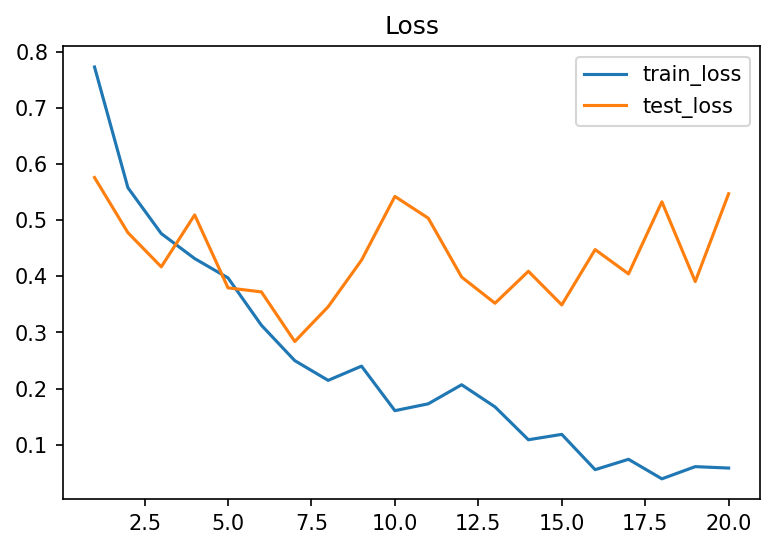

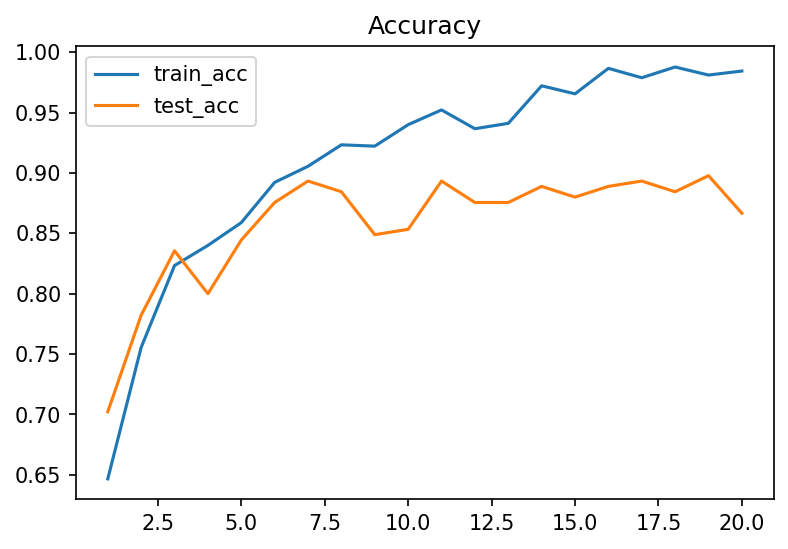

In [34]:
history=train(model, optim, loss_fn, train_dl, test_dl, epochs=20, device='cuda')

In [35]:
print(torch.cuda.is_available())

True


In [36]:
!nvidia-smi

Thu Dec  8 05:33:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |   1338MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   